In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
%matplotlib inline

plt.style.use('ggplot')

from faker import Faker

# задаем зерно
Faker.seed(12345)
 
names_list = []
 
fake = Faker()
for _ in range(100):
    names_list.append(fake.name())
 
# Зерно зарплат
# Если поставим зерно 5 то мы не увидим (привести пример)
np.random.seed(7)
salaries = []

# заполняем
for _ in range(100):
    salary = np.random.randint(5000,15000)
    salaries.append(salary)
 
# Создаём pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary (in USD)': salaries
    })
 
# Печатаем часть DataFrame
print(salary_df.head(6))

             Person  Salary (in USD)
0        Adam Bryan            14412
1         Jacob Lee             5537
2  Candice Martinez            10699
3   Justin Thompson             9307
4     Heather Rubio             5919
5   William Jenkins             6372


Вручную изменяем зарплату двух человек, чтобы создать выбросы. Напримере невнимательности человека заполнявшим эту информацию


In [85]:
salary_df.at[11, 'Salary (in USD)'] = 10
salary_df.at[99, 'Salary (in USD)'] = 15
 
# Убеждаемся, что зарплата изменилась
print(salary_df.loc[11])
print(salary_df.loc[99])

Person             Jason Mcclure
Salary (in USD)               10
Name: 11, dtype: object
Person             Matthew Luna
Salary (in USD)              15
Name: 99, dtype: object


# Про методы

Большинство методов обнаружения выбросов моделируют "нормальные" данные (в смысле не-выбросы), а все остальное называют выбросами. Мы разберем визуальный метод анализа ящика с усами и два связанных метода моделирования выбросов (а не нормальных данных).

## Графическое обнаружение и boxplot.

**Находим аномалии глазами**


Появление аномалий напрямую зависит от генерации самих данных. (минимальное значение, максимальное, значение 1-го квартиля и т. д.) в виде ящика с усами (диаграммы размаха):
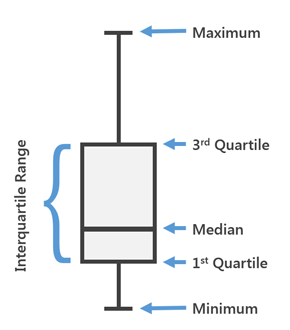

### Почему 1.5 IQR

Вспомним нормальное распределение:
<img src="https://miro.medium.com/max/1400/1*ARpoeY3MdhFImq0JXAXtRw.png">

и еще один факт о нем - $Q1 = -0.675\sigma$ a $Q3 = 0.675\sigma$

Поехали считать, сколько процентов наблюдений будет между  $Q1 - n*IQR$ и  $Q3 + n*IQR$

Если взять $n=1$, то 


$$Q1 - 1 * IQR = Q1 - 1 * (Q3 - Q1) = -0.675\sigma - 1 * (0.675 - [-0.675])\sigma = -0.675σ - 1 * 1.35\sigma = -2.025\sigma$$


$$Q3 + 1 * IQR = Q3 + 1 * (Q3 - Q1) = 0.675\sigma + 1 * (0.675 - [-0.675])\sigma = 0.675σ + 1 * 1.35\sigma = 2.025\sigma$$

Тогда почти 5% наблюдений будут названы выбросами. Кажется, что многовато, почему-то мы решили, что примерно до $3\sigma$ наблюдения полезны.

Таким перебором можно обнаружить, что для получения $3\sigma$ надо взять $n = 1.7$, но это "как-то несимметрично", поэтому взяли 1.5 

### Ответ:

1) Потому что мы хотели бы для нормальной выборки записывать в выбросы не слишком много объектов

2) Потому что мы любим "симметрию" и красивые числа

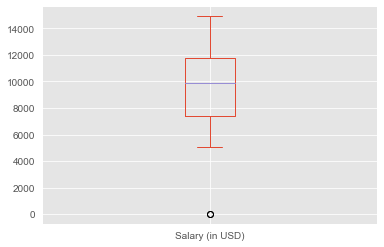

In [86]:
# Генерируем ящик с усами
salary_df['Salary (in USD)'].plot(kind='box')
plt.show()

Маленький кружок в самом низу даёт понять, что что-то не так, почему-то он сильно отличается от остальных данных. 

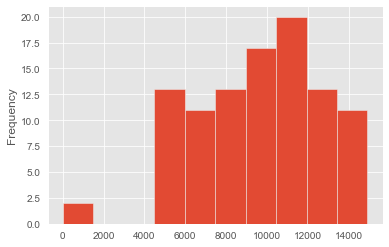

In [87]:
# Генерируем гистограмму
salary_df['Salary (in USD)'].plot(kind='hist')
plt.show()

Видна ячейка выбивающаяся ячейка на графике.. Ось Y даёт понять, что зарплата искажена только у двух сотрудников.

Но в большинстве случаев это нам даст только минимаксный алгоритм. Что не подойдет например для волновых функций. (пример позже)

Какой же способ сразу подтвердит наличие аномалий в наборе данных? Давайте посмотрим на минимальное и максимальное значение столбца «Заработная плата» (Salary):

In [88]:
# Минимальная и максимальная зарплата
print('Minimum salary ' + str(salary_df['Salary (in USD)'].min()))
print('Maximum salary ' + str(salary_df['Salary (in USD)'].max()))

Minimum salary 10
Maximum salary 14920


Минимальное значение явно отклоняется от того, что было задано раньше (5000 долларов). 


Следовательно, это действительно аномалия. 


Хотя наш набор данных содержит только один признак (зарплату), в настоящих датасетах аномалии могут встречаться в разных признаках. Но даже там такие визуализации помогут нам их обнаружить.

## Кластерный подход для обнаружения аномалий


Кластеризация и поиск аномалий тесно связаны, кластеризацию можно использовать для детектирования выбросов. В данном решении мы воспринимаем аномалии в виде групп похожих объектов. Математически их схожесть измеряется такими функциями, как евклидово расстояние, манхэттенское расстояние и т. д. Евклидово расстояние — самое распространённое.

Когда говорим про данный алгоритм, мы предполагаем что непохожесть элементов можем определить как расстояние между ними. На самом деле это небывалая роскошь.


Недостатки:


1. O(n2) — квадратичная сложность.
2. Не можем получить оценку аномалий дальше последнего к-го соседа.

##                                                    Евклидово расстояние


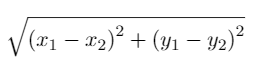


Если в двумерном пространстве есть n точек и их координаты обозначены (x_i, y_i), то евклидово расстояние между любыми двумя точками x1, y1 и x2, y2 равно:

Для кластеризации мы будем используется метод k-средних. 

In [89]:
# Конвертиртация зарплаты в массив numpy
salary_raw = salary_df['Salary (in USD)'].values
 
# совместимость с SciPy 
salary_raw = salary_raw.reshape(-1, 1)
salary_raw = salary_raw.astype('float64')


Применим kmeans к salary_raw:

In [90]:
from scipy import cluster
from scipy.cluster.vq import kmeans
    
# передаём данные и число кластеров в kmeans
# зарплата и кол-во кластеров
centroids, avg_distance = kmeans(salary_raw, 5)

centroids — это центроиды, сгенерированные kmeans, 

avg_distance — усреднённое евклидово расстояние между ними и точками. 


**vq(точки данных, центроид, сгенерированный алгоритмом кластеризации)** 


Метод возвращает группы точек (кластеры) и расстояния между точками и ближайшими кластерами.

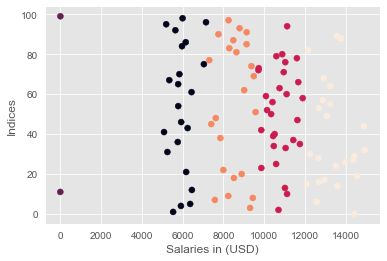

In [91]:
# Получаем кластеры и расстояния
groups, cdist = cluster.vq.vq(salary_raw, centroids)

# Рисуем график
plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('Salaries in (USD)')
plt.ylabel('Indices')
plt.show()

Теперь вы точно смогли увидеть аномалии. Итак, несколько моментов, которые необходимо учитывать перед обучением модели:

1. Тщательно изучите данные — взгляните на каждый признак в наборе, соберите статистику.
2. Постройте несколько полезных графиков (как показано выше), так вам будет легче заметить отклонения.
3. Посмотрите, как признаки связаны друг с другом. Это поможет выбрать наиболее значимые из них и отказаться от тех, что не влияют на целевую переменную (не коррелируют с ней).

4. Вышеуказанный метод обнаружения аномалий — пример обучения без учителя. Если бы у нас были метки классов, мы могли бы легко превратить процесс в обучение с учителем и рассматривать его как проблему классификации.

## Другой пример

In [92]:
from scipy import stats

In [93]:
X1 = stats.norm.rvs(loc=10, scale=2, size=(900,1000))
X2 = stats.norm.rvs(loc=10, scale=2, size=(900,1000))

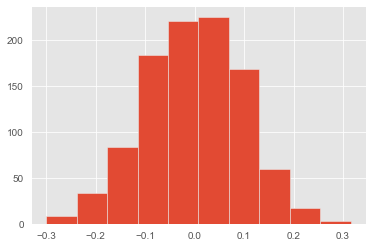

In [94]:
_ = plt.hist(X2.mean(axis=0) - X1.mean(axis=0))

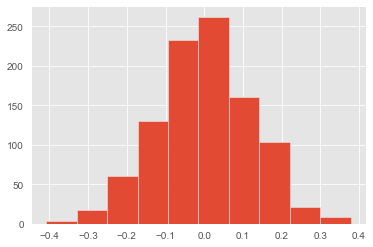

In [95]:
_ = plt.hist(np.median(X2,axis=0) - np.median(X1,axis=0))

In [96]:
X1 = stats.norm.rvs(loc=10, scale=2, size=(900,1000))
X2 = stats.norm.rvs(loc=10, scale=2, size=(894,1000))
X2 = np.vstack((X2,1000*np.ones((6, 1000))))

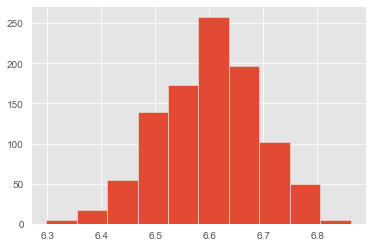

In [97]:
_ = plt.hist(X2.mean(axis=0) - X1.mean(axis=0))

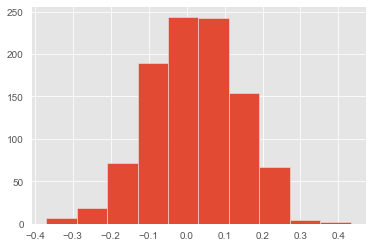

In [98]:
_ = plt.hist(np.median(X2,axis=0) - np.median(X1,axis=0))

## Модели, прогнозирующие величину в смысле среднего арифметического
**(например линейнаяm регрессия)**

In [99]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/abjidge/The-Complete-Guide-to-Linear-Regression-Analysis-with-Business-Problem/master/Advertising.csv', index_col=0)

In [100]:
print('df вида', df.shape)
df.head(5)

df вида (200, 4)


,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Text(0.5, 0, 'newspaper Advertising')

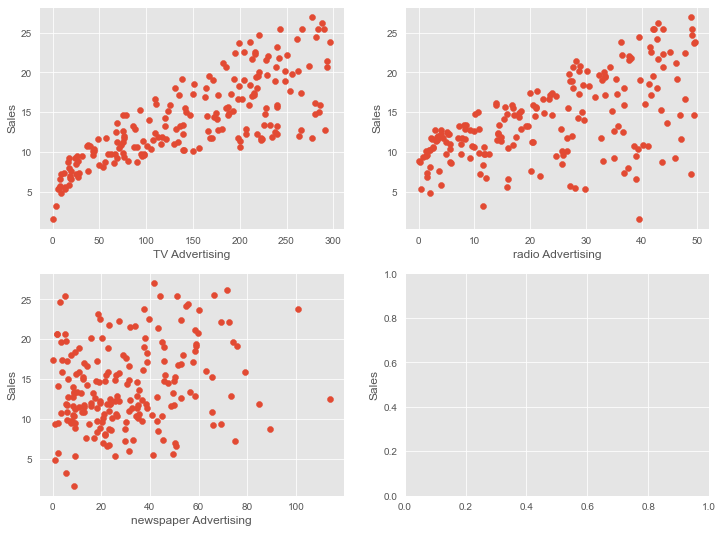

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize = (12,9))

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('Sales')
        
ax[0,0].scatter(x= df['TV'],y=df['sales'])
ax[0,1].scatter(x= df['radio'],y=df['sales'])
ax[1,0].scatter(x= df['newspaper'],y=df['sales'])
ax[0,0].set_xlabel('TV Advertising')
ax[0,1].set_xlabel('radio Advertising')
ax[1,0].set_xlabel('newspaper Advertising')

Очевидно, что никакой линейной регрессией здесь и не пахнет, но функция взята просто для примера. Можно немного "в тупую" преукрасить распределение чтобы оно стало более похожим на линейную регрессию. Взять корень например.
Линеаризируем первые 2 графика.

Text(0.5, 0, 'sqrt radio Advertising')

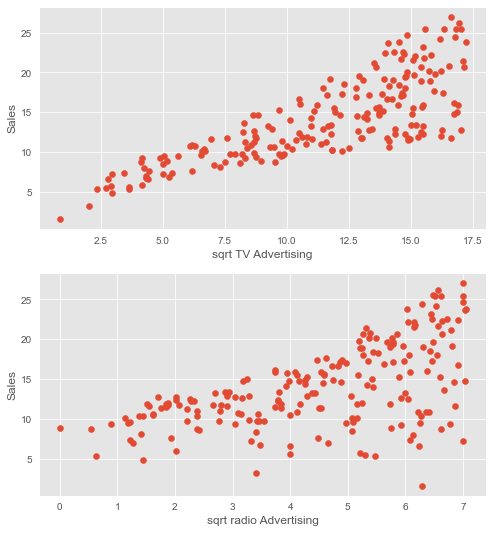

In [102]:
import numpy as np 

df['sqrt_tv'] = df['TV'].apply(lambda x: np.sqrt(x))
df['sqrt_radio'] = df['radio'].apply(lambda x: np.sqrt(x))
fig, ax = plt.subplots(2,1, figsize = (8,9))

for i in range(2):
    ax[i].set_ylabel('Sales')
        
ax[0].scatter(x= df['sqrt_tv'],y=df['sales'])
ax[1].scatter(x= df['sqrt_radio'],y=df['sales'])
ax[0].set_xlabel('sqrt TV Advertising')
ax[1].set_xlabel('sqrt radio Advertising')


In [103]:
from sklearn.linear_model import LinearRegression

In [104]:
reg = LinearRegression().fit(df[['sqrt_tv','sqrt_radio']], df['sales'])
df['sqrt_model'] = reg.predict(df[['sqrt_tv','sqrt_radio']])

reg2 = LinearRegression().fit(df[['TV','radio']], df['sales'])
df['model'] = reg2.predict(df[['TV','radio']])

In [105]:
df

,TV,radio,newspaper,sales,sqrt_tv,sqrt_radio,sqrt_model,model
1,230.1,37.8,69.2,22.1,15.169047,6.148170,20.281362,20.555465
2,44.5,39.3,45.1,10.4,6.670832,6.268971,12.241063,12.345362
3,17.2,45.9,69.3,9.3,4.147288,6.774954,10.592339,12.337018
4,151.5,41.3,58.5,18.5,12.308534,6.426508,17.948522,17.617116
5,180.8,10.8,58.4,12.9,13.446189,3.286335,14.115098,13.223908
...,...,...,...,...,...,...,...,...
196,38.2,3.7,13.8,7.6,6.180615,1.923538,4.936891,5.364512
197,94.2,4.9,8.1,9.7,9.705668,2.213594,8.806613,8.152375
198,177.0,9.3,6.4,12.8,13.304135,3.049590,13.605449,12.768048
199,283.6,42.0,66.2,25.5,16.840428,6.480741,22.422699,23.792923


Признаки не отнормированы

In [106]:
print('Среднеквадратичная ошибка с корнем',
      np.sum((df['sales']-df['sqrt_model'])**2)/df.shape[0])
print('Среднеквадратичная ошибка без корня',
      np.sum((df['sales']-df['model'])**2)/df.shape[0],'\n')

print('Средняя абсолютная ошибка с корнем',
      np.sum(np.abs(df['sales']-df['sqrt_model']))/df.shape[0])
print('Средняя абсолютная  ошибка без корня',
      np.sum(np.abs(df['sales']-df['model']))/df.shape[0])

Среднеквадратичная ошибка с корнем 2.4891042086809083
Среднеквадратичная ошибка без корня 2.784569900338092 

Средняя абсолютная ошибка с корнем 1.203712588308708
Средняя абсолютная  ошибка без корня 1.2537471644234004


In [107]:
x=np.arange(0,26,0.5)
y=np.arange(0,26,0.5)

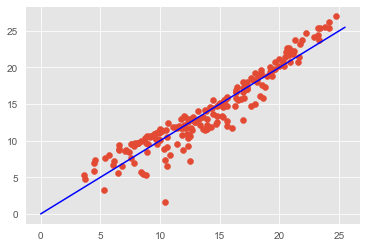

In [108]:
plt.scatter(x=df["model"], y=df["sales"])
plt.plot(x,y, c ='blue')

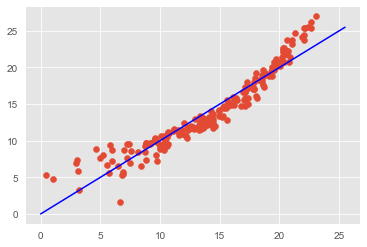

In [109]:
plt.scatter(x=df["sqrt_model"], y=df["sales"])
plt.plot(x,y, c ='blue')

Потрачено

Опять портим данные, при создании датасета случайно вбили два лишних нуля TV = 2000, sales = 5

In [110]:
add = pd.DataFrame([{'TV': 2000, 'radio': 45.9, 'newspaper': 69.3, 'sales': 5}])

In [111]:
df = pd.read_csv('https://raw.githubusercontent.com/abjidge/The-Complete-Guide-to-Linear-Regression-Analysis-with-Business-Problem/master/Advertising.csv', index_col=0)
df= df.append(add)

In [112]:
df.tail(5)

,TV,radio,newspaper,sales
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5
200,232.1,8.6,8.7,13.4
0,2000.0,45.9,69.3,5.0


In [113]:
reg2 = LinearRegression().fit(df[['TV','radio']], df['sales'])
df['model'] = reg2.predict(df[['TV','radio']])

In [114]:
print('Среднеквадратичная ошибка без корня',
      np.sum((df['sales']-df['model'])**2)/df.shape[0],'\n')

print('Средняя абсолютная  ошибка без корня',
      np.sum(np.abs(df['sales']-df['model']))/df.shape[0])

Среднеквадратичная ошибка без корня 17.06674230888933 

Средняя абсолютная  ошибка без корня 2.8502419138635533


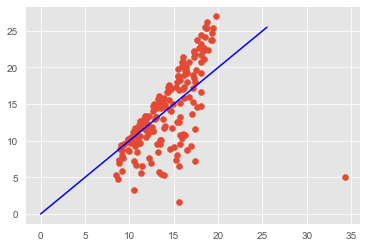

In [115]:
plt.scatter(x=df["model"], y=df["sales"])
plt.plot(x,y, c ='blue')

Кажется, что наша точка имеет достаточно экстремальное значение признака TV и эту точку можно быстро найти и, например, убить. В этом может помочь старый-добрый ящик с усами в простонародье известный как боксплот. Там есть какая-то присказка про то, что "за пределами усов" точки можно назвать выбросами. Вот давайте посмотрим, насколько мы сможем отловить выбросы таким методом и заодно разберемся, откуда взялось правило про длину этих усов.

Оказывается наши данные не совсем чистые и в значении TV указаны некорректные точки, нам необходимо их вычистить оттуда. Как мы уже знаем точки за пределами усов

<AxesSubplot:>

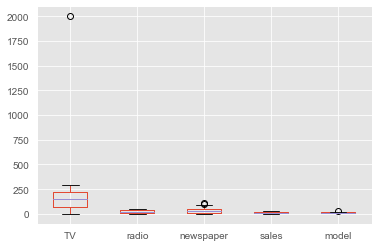

In [116]:
df.boxplot()

Вот странное значение и нашлось. Обычно за этим надо следить при построении моделей. 

Оказывается наши данные не совсем чистые и в значении TV указаны некорректные точки, нам необходимо их вычистить оттуда. Точки за пределами усов дают возможность нам понять, что они и являются нашими искомыми выбросами. Вот давайте посмотрим, насколько мы сможем отловить выбросы таким методом и заодно разберемся, откуда взялось правило про длину этих усов.

# Isolation Forest

Этот алгоритм использует идеи случайного леса для присвоения точкам "скора" нормальности. Представим дерево, которое на каждом шаге выбирает случайный признак и случайное значение этого признака (из интервала от минимума до максимума выбранного признака), а остальную выборку делит пополам - та часть, у которой значения признака больше, и та, у которой меньше. Так дерево можно строить рекурсивно до какой-то наперед заданной глубины или пока все не переберется. Такое дерево называется "Изоляционным" деревом или iTree. А теперь магия: если выброс - точка, которая "выпадает" из общего распределения, то она в таком дереве будет находиться выше, чем средняя "нормальная" точка. 

Иллюстрация:

<img src="https://miro.medium.com/max/1400/1*ujfv7WJH-tL1cRLxYEoicg.png">

Наше дерево как будто бы набрасывает прямые, параллельные координатным осям (нашим признакам) в пространство и тем самым делит его на сегменты. Теперь можно построить лес из таких деревьев. Тогда для каждого дерева нужно взять не весь набор точек, а его подмножество фиксированного размера. Осталось только разобраться, как измерить, что считается аномальным, а что нормальным. 

### Формула:

$$score = e^{-\dfrac{E(h(n))}{c(n)}}$$

$E(h(n))$ - усредненная по всем деревьям длина пути до точки 

$с(n)$ - средняя длина пути до точки (в бинарных деревьях поиска эта штука известна как "средняя длина неудачного поиска")

$c(n) = 2H_{n-1}-\dfrac{2(n-1)}{n}$

$H_{n-1}$ - гармоническое число


Если скор близок к 0, то точка аномальная, если близок к 1, то нормальная. Отсечку часто ставят на значении 0.5.

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Обучение
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Нормальные наблюдения
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Выбросы
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

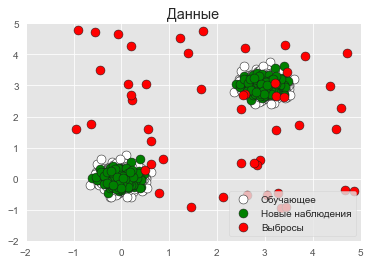

In [118]:
# Рисовалка
plt.title("Данные")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green',
                 s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red',
                s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["Обучающее",
            "Новые наблюдения", "Выбросы"],
           loc="lower right")

plt.show()

In [119]:
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=rng)
clf.fit(X_train)

# Предсказания
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

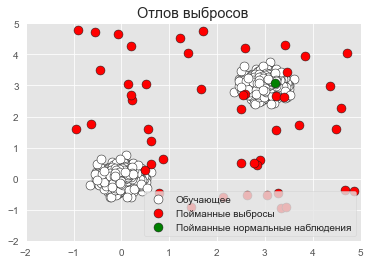

In [120]:
X_outliers = X_outliers.assign(y = y_pred_outliers)

plt.title("Отлов выбросов")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["Обучающее",
            "Пойманные выбросы", 
            "Пойманные нормальные наблюдения"],
           loc="lower right")


plt.show()

[Читать](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) про IsolationForest в sklearn

# Extended Isolation Forest

Конечно, любой метод можно попытаться "докрутить", IsolationForest доработали [тут](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)

**Зачем**

Если ваш набор точек имеет некоторую сложную структуру, обработать ее с помощью линий, параллельных осям координат может оказаться непросто даже для двумерного случая. Примеры разброса точек:

<img src="https://github.com/sahandha/eif/raw/master/figures/Training.png">

Тепловая карта скора, полученного стандартным IsolationForest:

<img src="https://github.com/sahandha/eif/raw/master/figures/scores_maps.png">

Видно, что многое перемешалось.

Давайте вместо линий(гиперплоскостей), параллельных осям будем набрасывать просто случайные гиперплоскости(без условия параллельности осям).

Тогда наши разбиения плоскостями примут вид:
<img src="https://github.com/sahandha/eif/raw/master/figures/Ex1.png">

Сделаем два кластера точек

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed

In [122]:
mean1 = [10, 0]
cov1 = [[1, 0], [0, 1]]  

mean2 = [0, 10]
cov2 = [[1, 0], [0, 1]]

Nobjs = 500          # Сколько точек брать
np.random.seed(1)    

x1, y1 = np.random.multivariate_normal(mean1, cov1, int(Nobjs/2)).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, int(Nobjs/2)).T

# Собираем в один датасет
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
X=np.array([x,y]).T

Картиночка

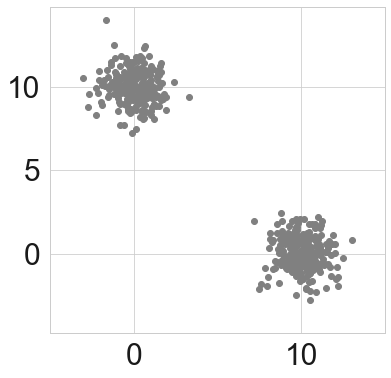

In [123]:
fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o', color=[0.5,0.5,0.5])
plt.grid("off")
plt.axis("equal")

plt.xlim([-5,15])
plt.ylim([-5,15])
plt.tick_params(direction='out', length=6, width=2, colors='k',labelsize=30)

plt.show()

Сравним результаты от обычного леса и "улучшенного"

In [124]:
F0  = iso.iForest(X,ntrees=500, sample_size=256, ExtensionLevel=0)
F1  = iso.iForest(X,ntrees=500, sample_size=256, ExtensionLevel=1)

In [125]:
# Скорим обучающую выборку
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

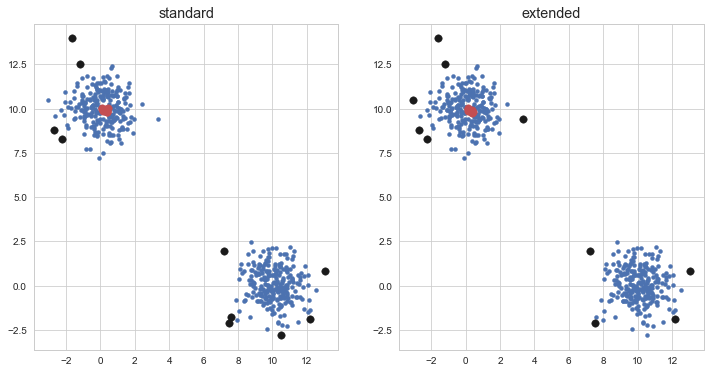

In [126]:
ss0=np.argsort(S0)
ss1=np.argsort(S1)

f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='k')
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r')
plt.title('standard')

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='k')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('extended')
plt.show()

Давайте теперь нарисуем тепловую карту скоров. 

In [127]:
xx, yy = np.meshgrid(np.linspace(-5, 15, 30), np.linspace(-5, 15, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

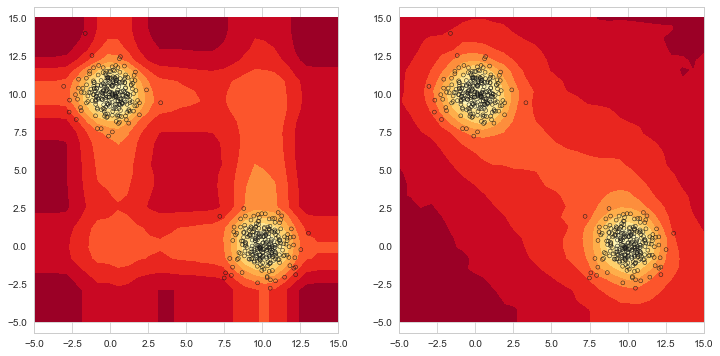

In [128]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


plt.show()